In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Load the pretrained DenseNet-169 model
model = DenseNet169(weights='imagenet')



In [ ]:
# Last Conv Layer

Resnet50 'conv5_block3_out'

InceptionV3 'mixed10'

Densenet169 'relu'

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1: class_id=243  imagenet_id=n02108422  bull_mastiff (0.47)
2: class_id=242  imagenet_id=n02108089  boxer (0.28)
3: class_id=254  imagenet_id=n02110958  pug (0.06)
4: class_id=245  imagenet_id=n02108915  French_bulldog (0.05)
5: class_id=282  imagenet_id=n02123159  tiger_cat (0.05)


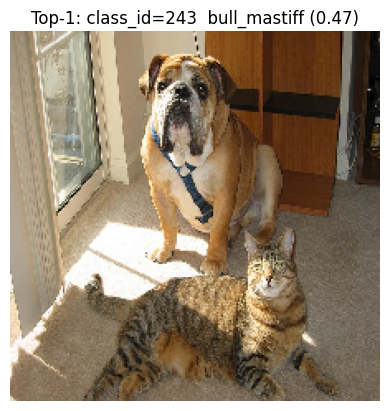

In [ ]:

# Preprocess image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Image path
img_path = '/content/cat dog.jpg'

# Preprocess input
img_array = preprocess_image(img_path)

# Predict
predictions = model.predict(img_array)[0]  # shape: (1000,)

# Get top-5 class indices (sorted)
top5_indices = predictions.argsort()[::-1][:5]

# Decode top-5 predictions
decoded_predictions = decode_predictions(np.expand_dims(predictions, axis=0), top=5)[0]

# Print top-5 predictions with class index
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    class_idx = top5_indices[i]
    print(f"{i + 1}: class_id={class_idx}  imagenet_id={imagenet_id}  {label} ({score:.2f})")

# Show image with Top-1 label
img = image.load_img(img_path, target_size=(224, 224))
top1_class_idx = top5_indices[0]
top1_id, top1_label, top1_score = decoded_predictions[0]

plt.imshow(img)
plt.title(f"Top-1: class_id={top1_class_idx}  {top1_label} ({top1_score:.2f})")
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
import cv2
from tensorflow.keras.preprocessing import image
from PIL import Image

def show_imgwithheat(img_path, heatmap, alpha=0.3, return_array=False):
    """Show the image with heatmap.

    Args:
        img_path: string.
        heatmap: image array, get it by calling grad_cam().
        alpha: float, transparency of heatmap.
        return_array: bool, return a superimposed image array or not.
    Return:
        None or image array.
    """
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # clipLimit -> Threshold for contrast limiting
    clahe = cv2.createCLAHE(clipLimit = 3,tileGridSize=(3,3))
    image = clahe.apply(image)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #print(heatmap.shape)
    #plt.imshow(heatmap)
    # threshold
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    hh, ww = thresh.shape
    # make bottom 2 rows black where they are white the full width of the image
    thresh[hh-3:hh, 0:ww] = 0

    # get bounds of white pixels
    white = np.where(thresh==255)
    xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
        #print(xmin,xmax,ymin,ymax)

        # crop the image at the bounds adding back the two blackened rows at the bottom
    crop = image[ymin:ymax+3, xmin:xmax]
    img = cv2.resize(crop,(224,224))
     #Images = np.expand_dims(Images,axis=3) #Extended dimension 3
       # display(np.expand_dims(img,axis=2))
      #  img = cv2.imread(img_path)
        #plt.imshow(heatmap)
    #print(heatmap.shape)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")

   # cv2.apply
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    imgwithheat = Image.fromarray(superimposed_img)
    try:
        display(imgwithheat)
    except NameError:
        imgwithheat.show()

    if return_array:
        return superimposed_img



CAM (Top-1 Prediction, No Gradients)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Top-1 class index: 243
Predicted: class_id=243  imagenet_id=n02108422  bull_mastiff (0.47)


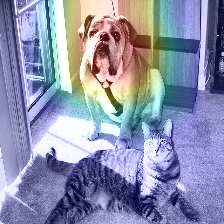

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.imagenet_utils import decode_predictions

def cam_top1(model, img, layer_name="conv5_block3_out"):
    """
    Generate CAM heatmap for the Top-1 predicted class (No gradients used).

    Args:
        model: A Keras model with a GAP layer before Dense layer.
        img: Preprocessed input image of shape (1, H, W, C).
        layer_name: Name of the final conv layer before GAP.

    Returns:
        heatmap: CAM heatmap of shape (H, W), normalized.
        predictions: Raw output probabilities from the model.
    """
    print("CAM (Top-1 Prediction, No Gradients)")

    # Get intermediate output of conv layer
    conv_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    conv_output = conv_model(img).numpy()[0]  # shape: (H, W, C)

    # Get prediction from model
    predictions = model.predict(img)
    top_class_idx = np.argmax(predictions[0])
    print(f"Top-1 class index: {top_class_idx}")

    # Get the weights of the Dense layer (shape: [num_features, num_classes])
    fc_weights = model.layers[-1].weights[0].numpy()  # assumes last layer is Dense

    # Get class-specific weights
    class_weights = fc_weights[:, top_class_idx]  # shape: (num_features,)

    # Weighted sum over feature maps
    cam = np.dot(conv_output, class_weights)  # shape: (H, W)

    # Normalize CAM
    cam = np.maximum(cam, 0)
    cam /= cam.max() + 1e-10

    # Decode predictions for label printing
    decoded = decode_predictions(predictions, top=1)[0][0]
    print(f"Predicted: class_id={top_class_idx}  imagenet_id={decoded[0]}  {decoded[1]} ({decoded[2]:.2f})")

    return cam, predictions


    # Example usage:
heatmap, prediction = cam_top1(model, img_array, layer_name="relu")
show_imgwithheat(img_path, heatmap)



CAM (Top-1 Prediction, No Gradients, Upscaled Activation Maps)


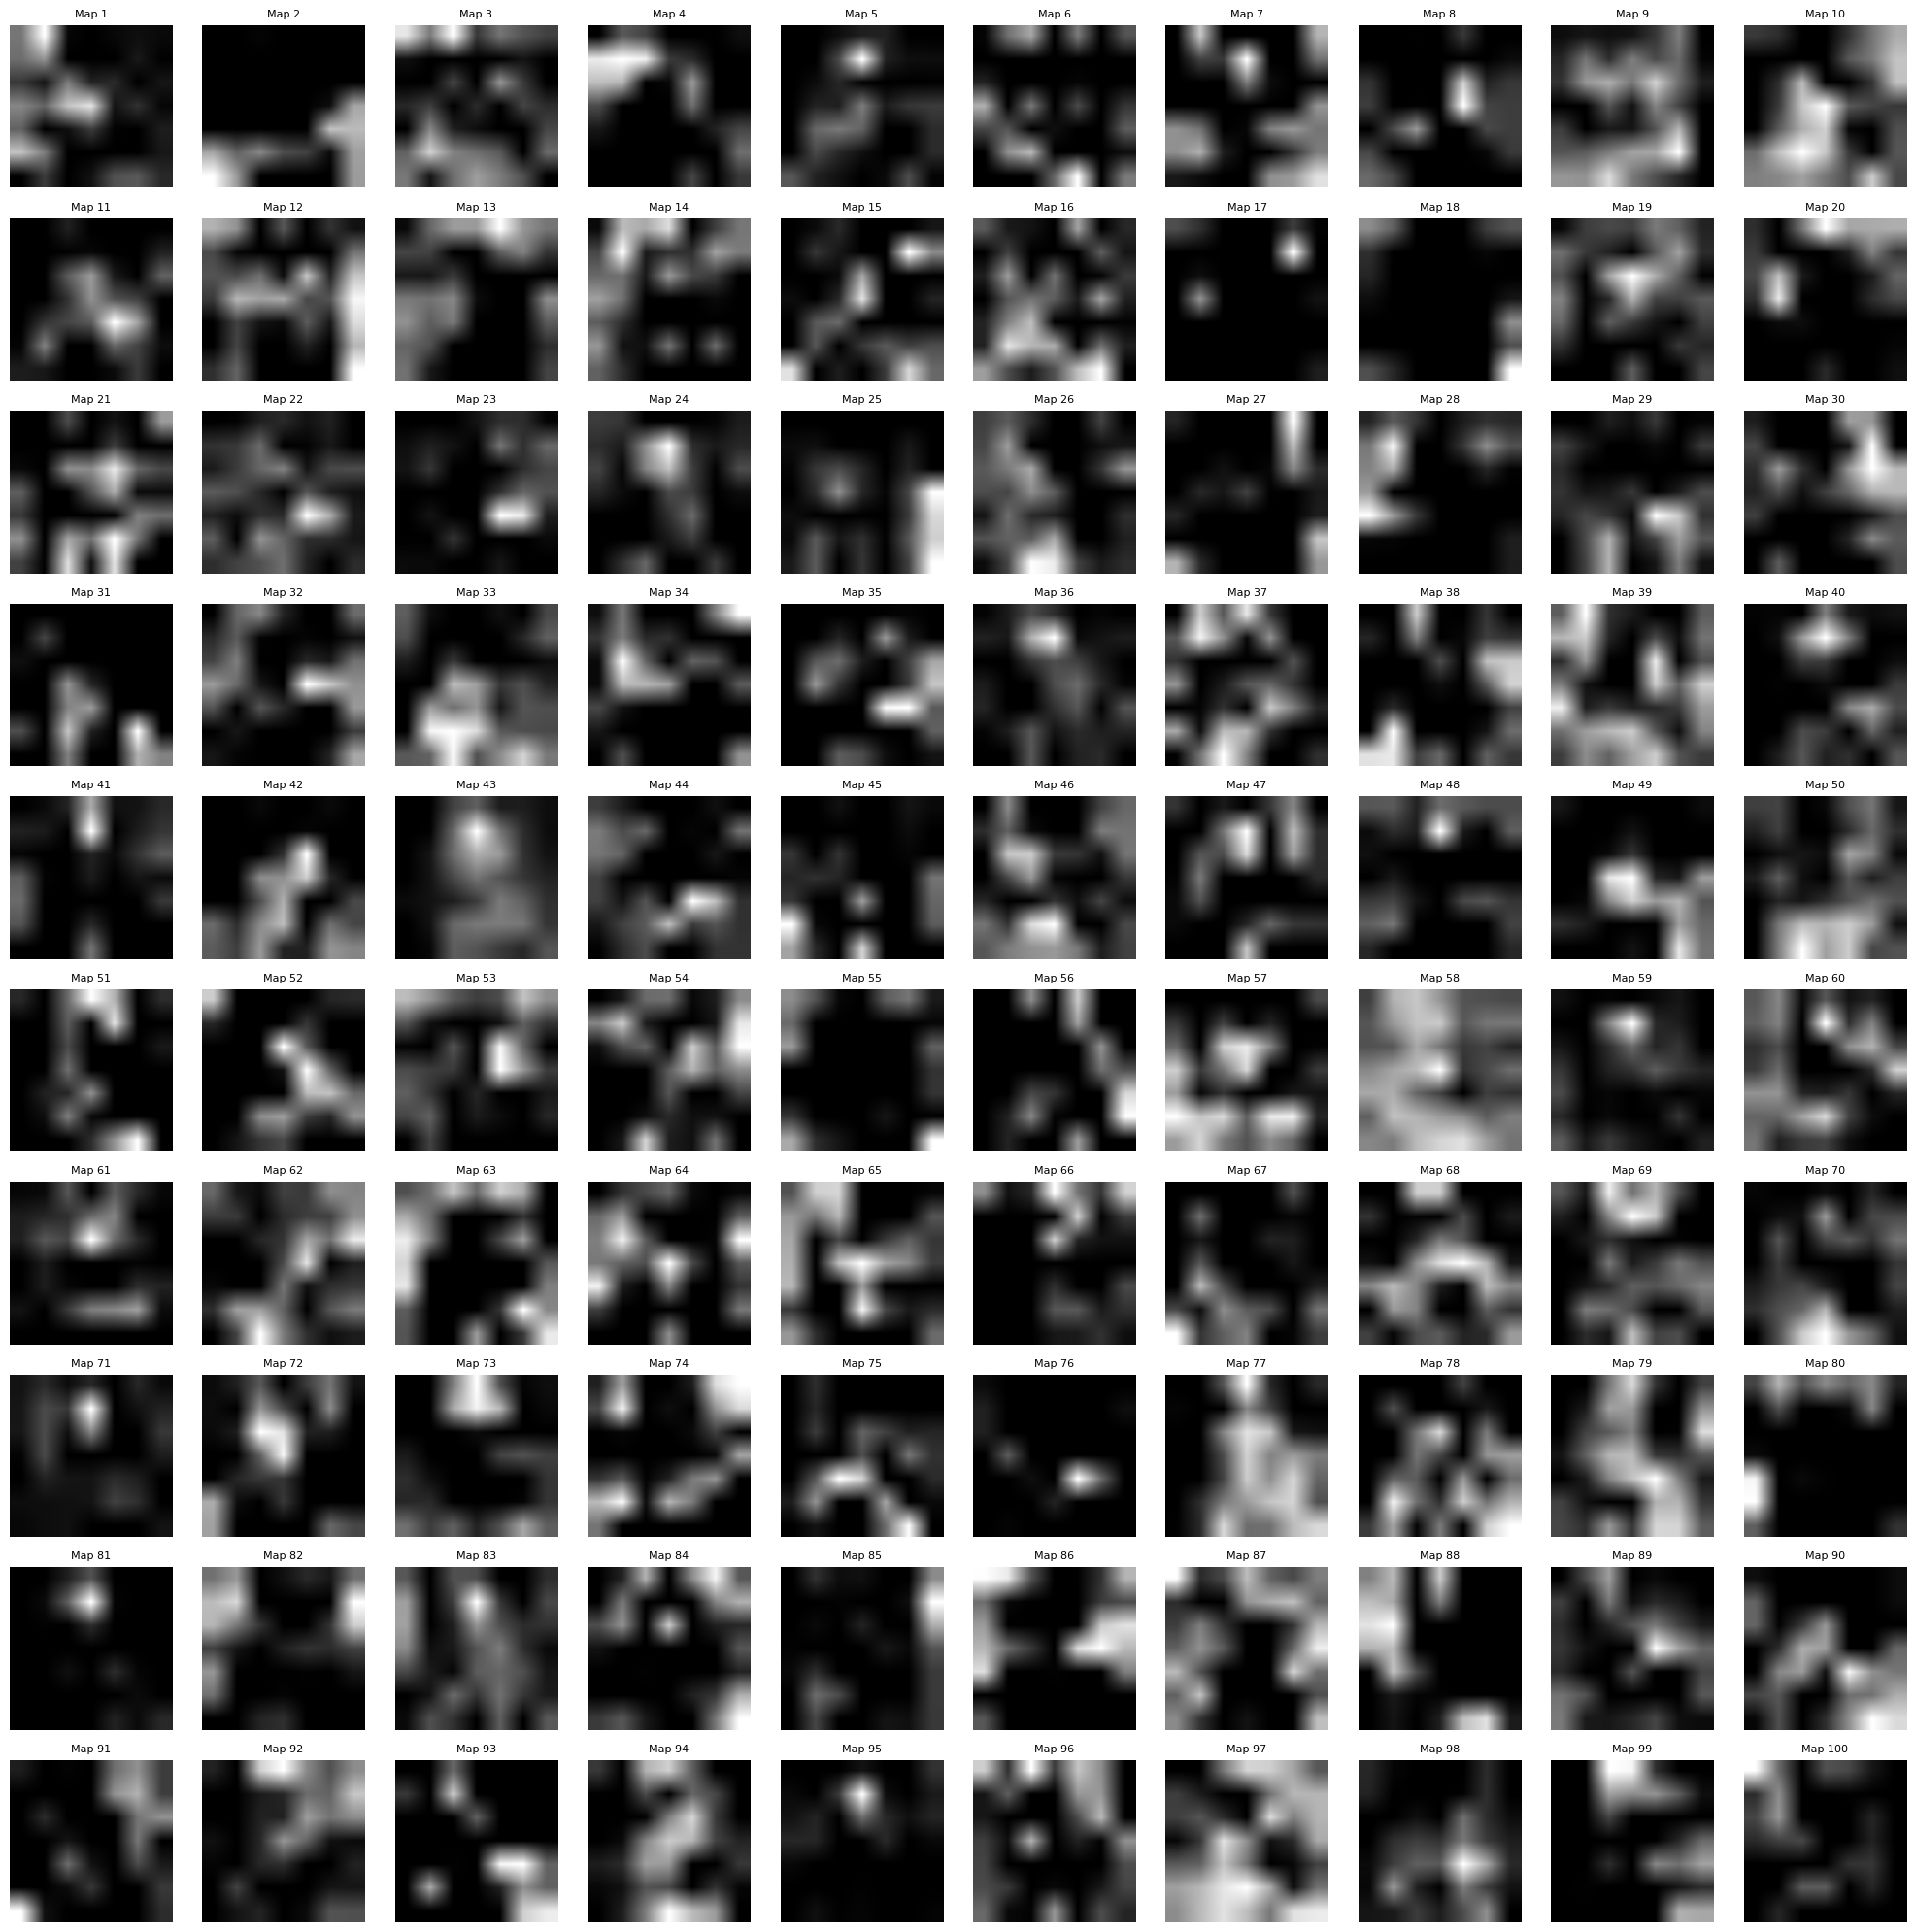

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Top-1 class index: 243
Predicted: class_id=243  imagenet_id=n02108422  bull_mastiff (0.47)


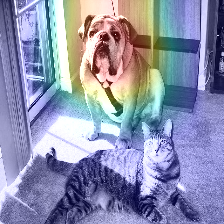

In [ ]:
import matplotlib.pyplot as plt
import cv2  # Make sure opencv-python is installed (`pip install opencv-python`)

def activationmap_upscaled(model, img, img_size=(224, 224), layer_name="conv5_block3_out"):
    """
    Generate CAM heatmap for the Top-1 predicted class (No gradients used),
    upscale each activation map to original image size and display.

    Args:
        model: A Keras model with a GAP layer before Dense layer.
        img: Preprocessed input image of shape (1, H, W, C).
        img_size: Tuple of original image size (height, width).
        layer_name: Name of the final conv layer before GAP.

    Returns:
        heatmap: CAM heatmap of shape (H, W), normalized.
        predictions: Raw output probabilities from the model.
    """
    print("CAM (Top-1 Prediction, No Gradients, Upscaled Activation Maps)")

    # Get intermediate output of conv layer
    conv_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    conv_output = conv_model(img).numpy()[0]  # shape: (h, w, channels)

    num_to_show = min(100, conv_output.shape[-1])
    orig_h, orig_w = img_size

    # Plot the activation maps in a grid, upscaled to original image size
    cols = 10
    rows = (num_to_show + cols - 1) // cols
    plt.figure(figsize=(20, 2 * rows))

    for i in range(num_to_show):
        ax = plt.subplot(rows, cols, i + 1)
        act_map = conv_output[:, :, i]

        # Normalize the activation map
        act_map -= act_map.min()
        if act_map.max() != 0:
            act_map /= act_map.max()

        # Upscale to original image size using cv2.resize (interpolation bilinear)
        act_map_upscaled = cv2.resize(act_map, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)

        ax.imshow(act_map_upscaled, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Map {i+1}", fontsize=8)

    plt.tight_layout()
    plt.show()

    # Get predictions and CAM heatmap as before
    predictions = model.predict(img)
    top_class_idx = np.argmax(predictions[0])
    print(f"Top-1 class index: {top_class_idx}")

    fc_weights = model.layers[-1].weights[0].numpy()
    class_weights = fc_weights[:, top_class_idx]
    cam = np.dot(conv_output, class_weights)

    cam = np.maximum(cam, 0)
    cam /= cam.max() + 1e-10

    decoded = decode_predictions(predictions, top=1)[0][0]
    print(f"Predicted: class_id={top_class_idx}  imagenet_id={decoded[0]}  {decoded[1]} ({decoded[2]:.2f})")

    return cam, predictions



  # Example usage:
heatmap, prediction = activationmap_upscaled(model, img_array, layer_name="relu")
show_imgwithheat(img_path, heatmap)



1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


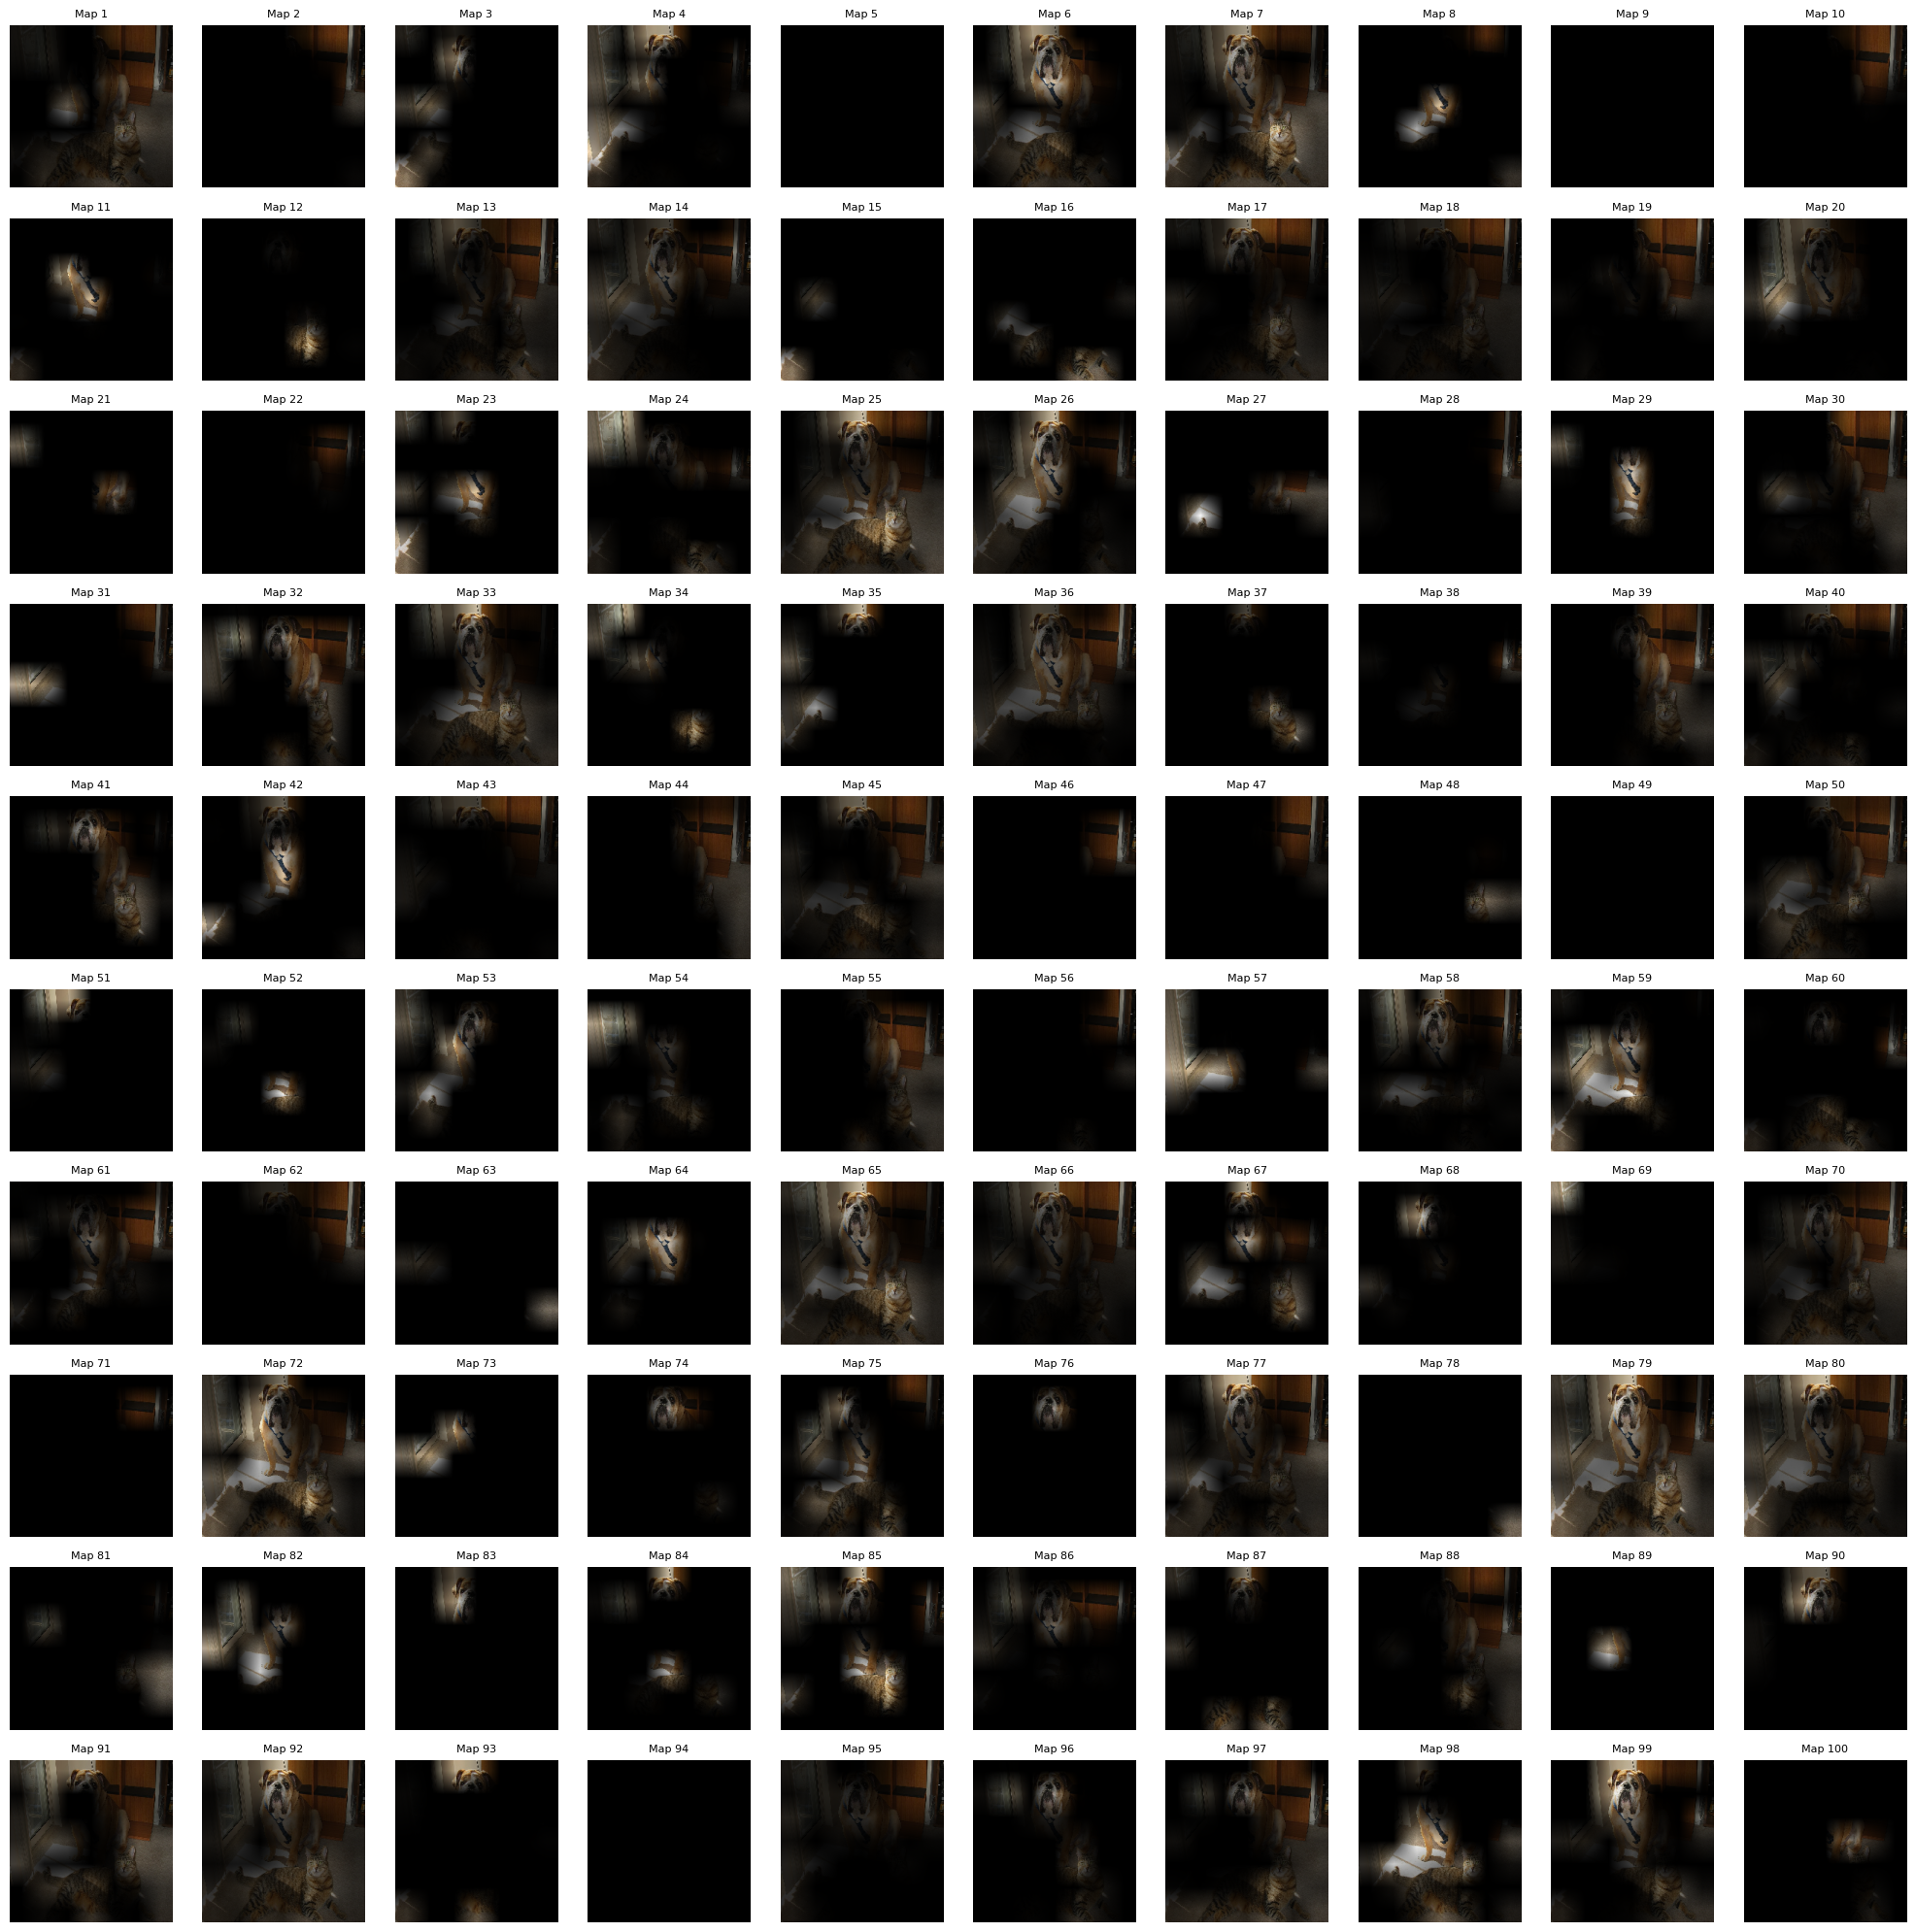

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input  # change as per your model
from tensorflow.keras.models import Model

def load_and_preprocess_image(img_path, target_size=(224,224)):
    # Load and resize
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  # shape (H, W, C), uint8 [0,255]
    img_array_exp = np.expand_dims(img_array, axis=0)  # (1, H, W, C)

    # Preprocess for model (e.g., normalize)
    img_preprocessed = preprocess_input(img_array_exp.copy())

    return img, img_preprocessed  # return original PIL img & preprocessed array

def perturb_activation_maps_with_original_img(model, img_path, layer_name="conv5_block3_out", max_maps=100):
    """
    Loads image from path, preprocesses it, extracts activation maps,
    perturbs the original image with upscaled activation maps and displays.
    """
    orig_img, img_preprocessed = load_and_preprocess_image(img_path)
    orig_h, orig_w = orig_img.size[1], orig_img.size[0]  # PIL size = (width, height)

    # Get conv layer output
    conv_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    conv_output = conv_model.predict(img_preprocessed)[0]  # (h, w, channels)

    num_maps = min(max_maps, conv_output.shape[-1])

    # Original image array normalized [0,1] for display and perturbation
    orig_img_array = np.array(orig_img) / 255.0  # (H, W, C) float32

    cols = 10
    rows = (num_maps + cols - 1) // cols
    plt.figure(figsize=(20, 2 * rows))

    for i in range(num_maps):
        act_map = conv_output[:, :, i]

        # Normalize activation map between 0-1
        act_map -= act_map.min()
        if act_map.max() != 0:
            act_map /= act_map.max()

        # Upscale to original image size
        act_map_upscaled = cv2.resize(act_map, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)
        act_map_upscaled = np.expand_dims(act_map_upscaled, axis=-1)  # (H, W, 1)

        # Perturb original image (elementwise multiply)
        perturbed_img = act_map_upscaled * orig_img_array

        # Clip to [0,1]
        perturbed_img = np.clip(perturbed_img, 0, 1)

        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(perturbed_img)
        ax.axis('off')
        ax.set_title(f"Map {i+1}", fontsize=8)

    plt.tight_layout()
    plt.show()


perturb_activation_maps_with_original_img(model, img_path='/content/cat dog.jpg', layer_name="relu")


Grad-CAM (Top-1 Prediction)
Top-1 class index: 243
Predicted: bull_mastiff (0.47)


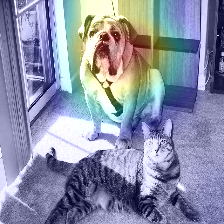

In [ ]:

def grad_cam_top1(model, img, layer_name="relu"):
    """
    Generate Grad-CAM heatmap for the Top-1 predicted class.

    Args:
        model: A pre-trained Keras model.
        img: Preprocessed image input as a NumPy array.
        layer_name: Name of the convolutional layer to use.

    Returns:
        heatmap: Grad-CAM heatmap (H x W)
        prediction: Full class probabilities (1 x num_classes)
    """
    print("Grad-CAM (Top-1 Prediction)")

    # Get the specified convolutional layer
    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model(inputs=model.inputs, outputs=[conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = heatmap_model(img)
        top_class_idx = tf.argmax(predictions[0])
        print(f"Top-1 class index: {top_class_idx.numpy()}")

        # Get score for top-1 class
        top_class_output = predictions[:, top_class_idx]

    # Compute gradient of the top class w.r.t. conv layer output
    grads = tape.gradient(top_class_output, conv_output)

    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply feature maps by pooled grads
    conv_output = conv_output[0]  # remove batch dimension
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

    # Apply ReLU and normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-10

    # Optionally print class label
    decoded = decode_predictions(predictions.numpy(), top=1)[0][0]
    print(f"Predicted: {decoded[1]} ({decoded[2]:.2f})")

    return heatmap, predictions

# Example usage:
heatmap, prediction = grad_cam_top1(model, img_array, layer_name="relu")
show_imgwithheat(img_path, heatmap)


Grad-Cam


1: n02108422  bull_mastiff (0.47)
2: n02108089  boxer (0.28)
3: n02110958  pug (0.06)
4: n02108915  French_bulldog (0.05)
5: n02123159  tiger_cat (0.05)
Processing category-id 243
0
Processing category-id 242
1
Processing category-id 254
2
Processing category-id 245
3
Processing category-id 282
4
Predicted Class: 243


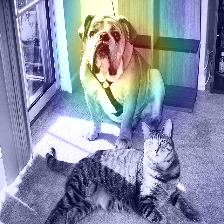

Predicted Class: 242


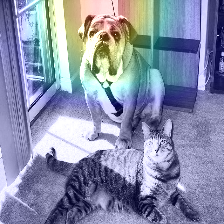

Predicted Class: 254


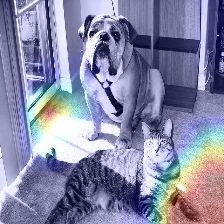

Predicted Class: 245


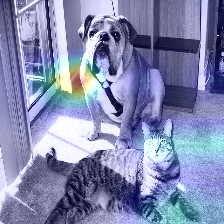

Predicted Class: 282


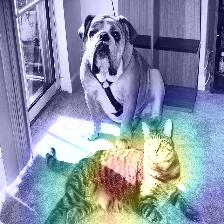

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.decomposition import TruncatedSVD


def grad_cam(model, img, layer_name="relu", top_k=5,test=False,idx=-1,label_name=None):
  """
  Get heatmaps by Grad-CAM for the top K predicted classes for ImageNet classification.

  Args:
      model: A pre-trained Keras model for ImageNet classification.
      img: An image array preprocessed for ImageNet (e.g., resized, normalized).
      layer_name: A string, name of the last convolutional layer (default: "conv5_block3_out" for many pre-trained models).
      top_k: An integer, number of top classes to generate heatmaps for (default: 3).

  Returns:
      A numpy array of shape (top_k, heatmap_height, heatmap_width) containing heatmaps.
  """

  # Preprocess image for ImageNet (assuming you haven't done it already)

  # Get the convolutional layer and create a heatmap model
  print("Grad-Cam")
  conv_layer = model.get_layer(layer_name)
  heatmap_model = Model(inputs=model.inputs, outputs=[conv_layer.output, model.output])


  with tf.GradientTape(persistent=True) as gtape:
    conv_output, predictions = heatmap_model(img)

    # Get top K predicted classes and probabilities
    sorted_indices=np.argsort(np.squeeze(predictions))[::-1]
    top_k_indices = sorted_indices[:5]

#     top_k_probs = predictions[0][top_k_indices]

    # Create an empty array to store heatmaps
    heatmaps = np.zeros((top_k, conv_output.shape[1], conv_output.shape[2]))


    decoded_predictions = decode_predictions(np.array(predictions), top=top_k)[0]
    for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
        print(f"{i + 1}: {imagenet_id}  {label} ({score:.2f})")
    # Calculate heatmap for each top class
    for i, category_id in enumerate(top_k_indices):
      print("Processing category-id",category_id)
      output = predictions[:, category_id]  # Select specific class prediction
      grads = gtape.gradient(output, conv_output)
      pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


      heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
      heatmap = np.maximum(heatmap, 0)
      print(i)
      max_heat = np.max(heatmap)
      if max_heat == 0:
        max_heat = 1e-10
      heatmap /= max_heat
      heatmaps[i, :, :] = heatmap


  return np.squeeze(heatmaps),top_k_indices

heatmaps, decoded_predictions= grad_cam(model,img_array,layer_name='relu')

for i in range(len(heatmaps)):
    print("Predicted Class:", decoded_predictions[i])
    show_imgwithheat(img_path ,heatmaps[i])


